# Grad-CAM with pytorch-grad-cam

https://github.com/jacobgil/pytorch-grad-cam

In [ ]:
import torch
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.ToPureTensor(),
])

dataset = datasets.Imagenette(
    root='./data',
    split='val',
    size='320px',
    transform=transform,
)

idx_to_class = {i:dataset.classes[i] for i in range(len(dataset.classes))}


import requests
url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
response = requests.get(url)
response.raise_for_status()
imagenet_idx_to_class = eval(response.text)

cuda


torch.Size([3, 224, 224])
(224, 224, 3)
torch.Size([1, 3, 224, 224])
(1, 224, 224)
(224, 224)
(224, 224, 3)
Real : ('golf ball',)
Pred [574]: golf ball


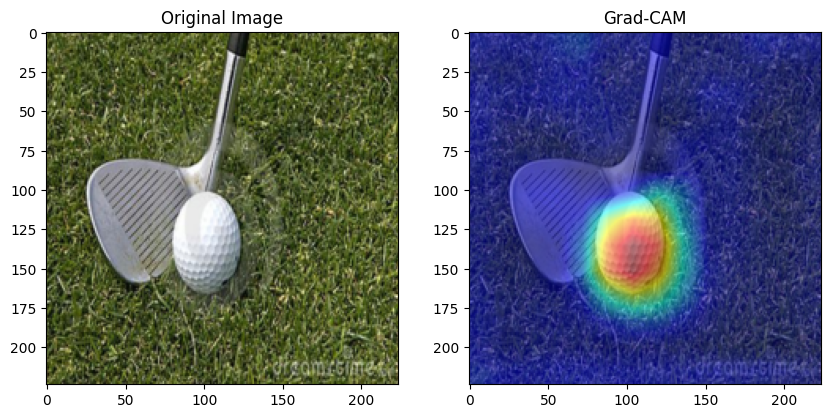

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image

i = torch.randint(0, len(dataset), (1,)).item()
img, lbl = dataset[i]
print(img.shape)
rgb_img = img.permute(1, 2, 0).numpy()
print(rgb_img.shape)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

model = models.vgg19(weights="DEFAULT").to(device)
target_layers = [model.features[-2]]
input_tensor = preprocess_image(rgb_img,
                                mean=mean,
                                std=std).to(device)

print(input_tensor.shape)
pred = model(input_tensor)
pred_idx = torch.argmax(pred, dim=1).item()

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = None

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, 
                        targets=targets)
    print(grayscale_cam.shape)
    grayscale_cam = grayscale_cam[0, :]
    print(grayscale_cam.shape)
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    print(cam_image.shape)


true_class = idx_to_class[lbl]
pred_class = imagenet_idx_to_class[pred_idx]

print(f"Real : {true_class}")
print(f"Pred [{pred_idx}]: {pred_class}")

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rgb_img)
ax.set_title("Original Image")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(cam_image)
ax.set_title("Grad-CAM")
plt.show()